In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
%matplotlib inline

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

height has been deprecated.



In [2]:
data = pd.read_csv('Training_dataset.csv')
# data.head(10)

In [3]:
data.drop(['application_key'],axis=1, inplace=True)
# data.head()

## Delete useless features

In [4]:
# cols = data.columns

# for i in cols:
#     count = data[i].isnull().sum()
#     if count>30000:
#         data.drop([i], axis=1, inplace=True)
# #     print (count)

In [5]:
new_cols = data.columns
print(len(new_cols))

48


In [6]:
print(new_cols)

Index(['mvar1', 'mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9', 'mvar10', 'mvar11', 'mvar12', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17', 'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24', 'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31', 'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38', 'mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45', 'mvar46', 'mvar47', 'default_ind'], dtype='object')


### Replace values in mvar47

In [7]:
# C=0  L=1

data['mvar47'].replace(to_replace='C', value=0, inplace=True)
data['mvar47'].replace(to_replace='L', value=1, inplace=True)

### Replace NaN values with median

In [8]:
data.fillna(value=data.median(axis=0), inplace=True)
print()

## Scale the data

In [9]:
feature = data.columns[:-1]
target = data.columns[-1]
X = data[feature]
y = data[target]

In [10]:
sc = StandardScaler()
X = sc.fit_transform(X)

## Principal Component Analysis

In [11]:
pca = PCA(n_components=2, random_state=1)
principal_components = pca.fit_transform(X)

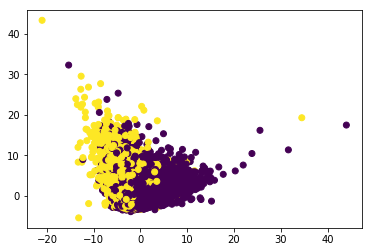

In [13]:
plt.scatter(principal_components[:,0],principal_components[:,1], c = y)

### DBSCAN to get noise points

In [14]:
# db = DBSCAN(eps=0.5, min_samples=5,n_jobs=2).fit(principal_components)
# labels = db.labels_
# n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

## Brute Force

In [15]:
principal_components = pd.DataFrame(principal_components)
drop_index = principal_components[(principal_components[principal_components.columns[0]] > 10) | (principal_components[principal_components.columns[1]]>25) | (principal_components[principal_components.columns[0]]<-9) | (4*principal_components[principal_components.columns[0]] + 5*principal_components[principal_components.columns[1]]>90 ) ].index
drop_index

Int64Index([  121,   441,   912,  1983,  2781,  2959,  3215,  3529,  3631,  4077,
            ...
            75877, 77122, 77702, 78280, 78633, 79047, 79066, 79425, 79610, 79984], dtype='int64', length=268)

### Drop those outliers

In [16]:
data.drop(drop_index, axis=0, inplace=True)
feature = data.columns[:-1]
target = data.columns[-1]
X = data[feature]
y = data[target]

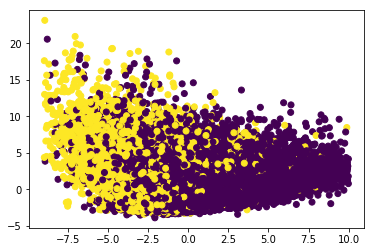

In [17]:
principal_components.drop(drop_index, axis=0, inplace=True)
principal_components = principal_components.as_matrix()
plt.scatter(principal_components[:,0],principal_components[:,1], c = y)

### Scale the data

In [18]:
sc = StandardScaler()
X = sc.fit_transform(X)

### Train test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Models

In [604]:
random = RandomForestClassifier(n_estimators=200, verbose=1, n_jobs=-1, oob_score=True, random_state=1)
boost = GradientBoostingClassifier(n_estimators=300,random_state=1)
xgboost = XGBClassifier()

In [605]:
random.fit(X_train, y_train)

train_score = random.score(X_train, y_train)
test_score = random.score(X_test, y_test)
oob_score = random.oob_score_

print(train_score)
print(test_score)
print(oob_score)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


1.0
0.810242474916388
0.804826918942163


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


## Grid search CV Random forest

In [183]:
rf = RandomForestClassifier(n_jobs=-1, oob_score=False, verbose=1, random_state=1)
param_grid = {'n_estimators':[200],
             'min_samples_leaf':[10],
             'min_samples_split':[2,5,10,20]
             }



CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid,scoring='roc_auc', cv= 3, verbose=1)
CV_rf.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tas

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=1, verbose=1, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'min_samples_leaf': [10], 'min_samples_split': [2, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [184]:
train_score = CV_rf.score(X_train, y_train)
test_score = CV_rf.score(X_test, y_test)

print(train_score)
print(test_score)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


0.9469456844543616
0.8344988980364405


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


In [185]:
CV_rf.best_params_

{'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}

## Grid Search CV XGboost

In [ ]:
######### This is for 910000 ############
param_grid = {'n_estimators': [200],
              'learning_rate': [0.2],
             'gamma': [1.5],
              'reg_lambda': [30]
             }
drop_index = principal_components[(principal_components[principal_components.columns[0]] > 10) | (principal_components[principal_components.columns[1]]>25) | (principal_components[principal_components.columns[0]]<-9) | (4*principal_components[principal_components.columns[0]] + 5*principal_components[principal_components.columns[1]]>90 ) ].index

In [20]:
xgb = XGBClassifier(n_jobs=4, silent=0, random_state=1)
# 'learning_rate':[0.01, 0.05, 0.1, 0.2],
param_grid = {'n_estimators': [200],
              'learning_rate': [0.2],
             'gamma': [1.5],
              'reg_lambda': [30]
             }



CV_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid,scoring='roc_auc', cv= 3, verbose=1)
CV_xgb.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=0,
       subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'learning_rate': [0.2], 'gamma': [1.5], 'reg_lambda': [30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [21]:
train_score = CV_xgb.score(X_train, y_train)
test_score = CV_xgb.score(X_test, y_test)

print(train_score)
print(test_score)

0.8544677437932956
0.8569290768350991


In [22]:
CV_xgb.best_params_

{'gamma': 1.5, 'learning_rate': 0.2, 'n_estimators': 200, 'reg_lambda': 30}

In [ ]:
new_boost = XGBClassifier(n_estimators=200,learning_rate=0.2, gamma=1.5,silent=False,reg_lambda=30, random_state=1, n_jobs=-1)
new_boost.fit(X, y)

train_score = new_boost.score(X_train, y_train)
test_score = new_boost.score(X_test, y_test)

print(train_score)
print(test_score)

# Leaderboard dataset

In [23]:
lead_data = pd.read_csv('Leaderboard_dataset.csv')
# lead_data.head(10)

In [24]:
lead_cols = ['application_key']+ list(data.columns)[:-1]
lead_data = lead_data[lead_cols]
lead_data.shape
# lead_data.head(10)

(25000, 48)

In [25]:
lead_data['mvar47'].replace(to_replace='C', value=0, inplace=True)
lead_data['mvar47'].replace(to_replace='L', value=1, inplace=True)

In [26]:
lead_data.fillna(value=lead_data.median(axis=0), inplace=True)
print("")

In [27]:
X_lead = lead_data[lead_data.columns[1:]]
print(type(X_lead))

<class 'pandas.core.frame.DataFrame'>


In [28]:
X_lead = X_lead.as_matrix()

In [29]:
X_lead = sc.fit_transform(X_lead)

## Submission part

In [37]:
predictions = predictions[:,1]

sub = pd.DataFrame()
sub['app_id'] = lead_data['application_key']
sub['pred'] = pd.Series(predictions)

sub.sort_values(by=['pred'],ascending=True, inplace=True)

sub['pred'] = [1 if x >=0.50 else 0 for x in sub['pred']]
sub = sub.as_matrix().astype(np.int64)

np.savetxt('Etching_coders_IITMadras_223.csv',sub,fmt='%5d', delimiter=",")

In [ ]:
# sub.to_csv('Etching_coders_IITMadras_109.csv',header=False,index=False)

## Outlier detection

In [ ]:
app1 = list(sub['app_id'][0:10000])
app2 = list(sub1['app_id'][0:10000])

In [ ]:
data.describe()

In [ ]:
stats = data.describe()
print(stats.index)

In [ ]:
list(stats.index) + ['IQ']

In [ ]:
IQ = []
for col in stats.columns:
    IQ.append(stats[col].loc['75%'] - stats[col].loc['25%'])

stats.loc['IQ'] = IQ

In [ ]:
up_cut = []
low_cut = []
for col in stats.columns:
    up_cut.append(1.5*stats[col].loc['IQ'] + stats[col].loc['75%'])
    low_cut.append(stats[col].loc['25%'] - 1.5*stats[col].loc['IQ'])

stats.loc['up_cut'] = up_cut
stats.loc['low_cut'] = low_cut

## Use leaderboard data to train

In [44]:
X_lead = lead_data[lead_data.columns[1:]]
X_lead = X_lead.as_matrix()
X_lead = sc.transform(X_lead)

In [431]:
# predictions = new_boost.predict_proba(X_lead)
predictions = CV_xgb.predict_proba(X_lead)
predictions.shape

(25000, 2)

In [432]:
predictions = predictions[:,1]

In [433]:
sub = pd.DataFrame()
sub['app_id'] = lead_data['application_key']
sub['pred'] = pd.Series(predictions)

In [434]:
sub['pred'] = [1 if x >=0.50 else 0 for x in sub['pred']]

In [435]:
new_lead_data = lead_data.copy()
new_lead_data['default_ind'] = sub['pred']
new_lead_data.head(2)

,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,mvar12,mvar13,mvar14,mvar16,mvar17,mvar18,mvar19,mvar20,mvar24,mvar25,mvar26,mvar27,mvar28,mvar29,mvar32,mvar33,mvar34,mvar36,mvar37,mvar38,mvar39,mvar42,mvar43,mvar44,mvar47,default_ind
0,350053,1753.0,0.5001,0.0,0.0,0.0,206.0,19179.0,206.0,14221.0,19438.0,785.0,4133.0,27748,0.0,0.0,0.0,1.0,1.0,79.20,1141.0,152.0,152.0,1551.0,8486.0,450.0,13.0833,0.0,3.0,11.0,1.0,0.0,0.42105,3.0,0.85661,1,0
1,350054,1894.0,1.9701,0.0,0.0,0.0,297.0,19820.0,19820.0,176895.0,66346.0,1816.0,944.0,89190,0.0,0.0,0.0,0.0,0.0,2.97,2186.0,4563.0,4563.0,30386.0,10220.0,1222.0,1.8333,0.0,3.0,12.0,3.0,0.0,0.00000,15.0,0.94391,0,0


In [436]:
new_lead_data.columns = ['application_key'] + list(data.columns)

In [437]:
new_lead_data.drop(['application_key'], axis=1, inplace=True)

In [52]:
new_lead_data.index = list(range(80000,105000))
frame = [data, new_lead_data]
new_train_data = pd.concat(frame)
# new_train_data = new_lead_data
print(new_train_data.shape)
new_train_data.tail()

(104755, 39)


,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,mvar12,mvar13,mvar14,mvar16,mvar17,mvar18,mvar19,mvar20,mvar21,mvar22,mvar24,mvar25,mvar26,mvar27,mvar28,mvar29,mvar32,mvar33,mvar34,mvar36,mvar37,mvar38,mvar39,mvar42,mvar43,mvar44,mvar46,mvar47,default_ind
104995,1715.0,12.0002,0.000,0.0,0.000,297.0,991.0,2503.0,8751.0,1814.0,0.0,656.0,475680,0.0,0.0,0.0,0.0,0.0,59.5695,0.00,0.00,274.0,1764.0,2555.0,30386.0,5262.0,9.0,3.0000,0.0,5.0,1.0,1.0,0.0,0.07692,4.0,0.73274,0.0,0,1
104996,1800.0,0.0551,0.000,0.0,0.000,5946.0,14867.0,9613.0,46490.0,44722.0,101.0,6118.0,148650,0.0,0.0,0.0,0.0,0.0,59.5695,0.00,0.24,1805.0,5384.0,4441.0,30386.0,7969.0,178.0,3.0833,0.0,2.0,1.0,4.0,0.0,0.05882,8.0,0.99859,0.0,1,0
104997,1686.0,1.3301,2.025,0.0,2.025,297.0,0.0,2503.0,4582.0,0.0,3017.0,0.0,99100,0.0,0.0,0.0,0.0,0.0,59.5695,3978.57,0.00,892.0,3772.0,1886.0,30.0,4167.0,176.0,0.0833,0.0,4.0,5.0,0.0,0.0,0.30000,2.0,0.77519,0.0,1,0
104998,1826.0,0.5424,0.428,0.0,0.000,3568.0,26277.0,9058.0,72739.0,86797.0,1494.0,23266.0,99100,0.0,0.0,1.0,0.0,1.0,8.6000,10140.00,4.73,2208.0,6600.0,4958.0,304.0,9308.0,726.0,33.2500,0.0,7.0,9.0,2.0,0.0,0.03333,11.0,0.40343,0.0,0,0
104999,1916.0,0.1394,0.000,0.0,0.000,18889.0,18889.0,18889.0,28343.0,51174.0,931.0,43374.0,148650,0.0,0.0,0.0,0.0,0.0,4.6950,3978.57,4.70,3802.0,5232.0,5232.0,30386.0,6905.0,500.0,13.0833,0.0,2.0,4.0,0.0,0.0,0.00000,5.0,0.99663,0.0,0,0


### Training on the new dataset

In [53]:
feature = new_train_data.columns[:-1]
target = new_train_data.columns[-1]
X = new_train_data[feature]
y = new_train_data[target]
# X = X.as_matrix()
# y = y.as_matrix()

In [54]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [55]:
xgb = XGBClassifier(n_jobs=4, silent=False, random_state=1)
# 'learning_rate':[0.01, 0.05, 0.1, 0.2],
param_grid = {'n_estimators': [200],
              'learning_rate': [0.2],
              'gamma': [1.5],
              'reg_lambda': [30]
             }



CV_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid,scoring='roc_auc', cv= 3, verbose=1)
CV_xgb.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'learning_rate': [0.2], 'gamma': [1.5], 'reg_lambda': [30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [57]:
train_score = CV_xgb.score(X_train, y_train)
test_score = CV_xgb.score(X_test, y_test)

print(train_score)
print(test_score)

0.8803181892061337
0.8772688571887564


In [438]:
predictions = CV_xgb.predict_proba(X_lead)
# predictions = CV_mlp.predict_proba(X_lead)
predictions.shape

(25000, 2)

In [439]:
predictions = predictions[:,1]

In [440]:
sub = pd.DataFrame()
sub['app_id'] = lead_data['application_key']
sub['pred'] = pd.Series(predictions)

In [441]:
sub.sort_values(by=['pred'],ascending=True, inplace=True)

In [442]:
sub['pred'] = [1 if x >=0.50 else 0 for x in sub['pred']]
sub = sub.as_matrix().astype(np.int64)

In [443]:
np.savetxt('Etching_coders_IITMadras_251.csv',sub,fmt='%5d', delimiter=",")

# Stacking

In [143]:
mlp = MLPClassifier(hidden_layer_sizes=(400,300,200,50,25,12),verbose=True,early_stopping=True, random_state=1)

mlp.fit(X, y)

Iteration 1, loss = 0.42902535
Validation score: 0.791499
Iteration 2, loss = 0.41689559
Validation score: 0.792001
Iteration 3, loss = 0.41358086
Validation score: 0.790246
Iteration 4, loss = 0.41094758
Validation score: 0.792503
Iteration 5, loss = 0.40827376
Validation score: 0.786610
Iteration 6, loss = 0.40661032
Validation score: 0.791625
Iteration 7, loss = 0.40442068
Validation score: 0.791249
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(400, 300, 200, 50, 25, 12),
       learning_rate='constant', learning_rate_init=0.001, max_iter=200,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=1,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [144]:
train_score = mlp.score(X_train, y_train)
test_score = mlp.score(X_test, y_test)

print(train_score)
print(test_score)

0.8051694490219962
0.8050319722489238


In [231]:
mlp = MLPClassifier(learning_rate='adaptive', verbose=True, early_stopping=True, random_state=1)
param_grid = {'alpha': [0.1],
              'learning_rate_init': [0.0001],
              'hidden_layer_sizes': [(200, 100, 75, 50, 25)]
             }



CV_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid,scoring='roc_auc', cv= 3, verbose=1)
CV_mlp.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Iteration 1, loss = 0.57002864
Validation score: 0.790256
Iteration 2, loss = 0.51730125
Validation score: 0.794771
Iteration 3, loss = 0.50611308
Validation score: 0.795899
Iteration 4, loss = 0.49919529
Validation score: 0.793642
Iteration 5, loss = 0.49360368
Validation score: 0.797968
Iteration 6, loss = 0.48859541
Validation score: 0.798345
Iteration 7, loss = 0.48449421
Validation score: 0.793454
Iteration 8, loss = 0.48086590
Validation score: 0.798157
Iteration 9, loss = 0.47756576
Validation score: 0.800978
Iteration 10, loss = 0.47442250
Validation score: 0.797780
Iteration 11, loss = 0.47185035
Validation score: 0.798533
Iteration 12, loss = 0.46890736
Validation score: 0.797216
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.57097338
Validation score: 0.803800
Iteration 2, loss = 0.51677763
Validation score: 0.807186
Iteration 3, loss = 0.50522847
V

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   52.2s finished


Iteration 1, loss = 0.55334333
Validation score: 0.794332
Iteration 2, loss = 0.50699900
Validation score: 0.793454
Iteration 3, loss = 0.49627349
Validation score: 0.796840
Iteration 4, loss = 0.48846567
Validation score: 0.796213
Iteration 5, loss = 0.48226622
Validation score: 0.797341
Iteration 6, loss = 0.47721669
Validation score: 0.797467
Iteration 7, loss = 0.47288765
Validation score: 0.799348
Iteration 8, loss = 0.46900741
Validation score: 0.799724
Iteration 9, loss = 0.46555375
Validation score: 0.799975
Iteration 10, loss = 0.46260543
Validation score: 0.799599
Iteration 11, loss = 0.45988969
Validation score: 0.800853
Iteration 12, loss = 0.45731504
Validation score: 0.797592
Iteration 13, loss = 0.45493629
Validation score: 0.801981
Iteration 14, loss = 0.45302648
Validation score: 0.800100
Iteration 15, loss = 0.45073106
Validation score: 0.799222
Iteration 16, loss = 0.44870897
Validation score: 0.801104
Validation score did not improve more than tol=0.000100 for two c

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1], 'learning_rate_init': [0.0001], 'hidden_layer_sizes': [(200, 100, 75, 50, 25)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [232]:
train_score = CV_mlp.score(X_train, y_train)
test_score = CV_mlp.score(X_test, y_test)

print(train_score)
print(test_score)

0.8431207338797967
0.843661720403483


In [233]:
CV_mlp.best_params_

{'alpha': 0.1,
 'hidden_layer_sizes': (200, 100, 75, 50, 25),
 'learning_rate_init': 0.0001}

### Feature importances

In [606]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=10, random_state=1)

rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [607]:
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print(train_score)
print(test_score)

0.8754568909911847
0.8765886287625418


In [608]:
imps = rf.feature_importances_

In [609]:
print(len(imps))

47


<Container object of 47 artists>

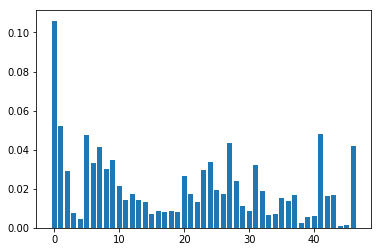

In [610]:
plt.bar(range(X.shape[1]),imps)

In [611]:
rem_inds = [x for x in range(len(imps)) if imps[x]<0.008]

In [612]:
len(rem_inds)

10

In [613]:
X.shape

(79732, 47)

In [614]:
new = pd.DataFrame(X)
cols = list(new.columns)
for i in rem_inds:
    cols.remove(i)
print(cols)

[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 41, 42, 43, 46]


In [615]:
new = new[cols]

In [616]:
new.shape

(79732, 37)

In [617]:
X = new.as_matrix()

In [618]:
xgb = XGBClassifier(n_jobs=4, silent=False, random_state=1)
# 'learning_rate':[0.01, 0.05, 0.1, 0.2],
param_grid = {'n_estimators': [200],
              'learning_rate': [0.2],
              'gamma': [1.5],
              'reg_lambda': [30]
             }



CV_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid,scoring='roc_auc', cv= 3, verbose=1)
CV_xgb.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'learning_rate': [0.2], 'gamma': [1.5], 'reg_lambda': [30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [619]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [620]:
train_score = CV_xgb.score(X_train, y_train)
test_score = CV_xgb.score(X_test, y_test)

print(train_score)
print(test_score)

0.8524006160806901
0.854470179162024


In [621]:
X_lead.shape

(25000, 43)

In [631]:
old = pd.DataFrame(X_lead)

In [632]:
old = old[cols]
X_lead = old.as_matrix()
X_lead.shape

(25000, 37)

In [36]:
predictions = gnb.predict_proba(X_lead)
# predictions = CV_mlp.predict_proba(X_lead)
predictions.shape

predictions = predictions[:,1]

sub = pd.DataFrame()
sub['app_id'] = lead_data['application_key']
sub['pred'] = pd.Series(predictions)

sub.sort_values(by=['pred'],ascending=True, inplace=True)

sub['pred'] = [1 if x >=0.50 else 0 for x in sub['pred']]
sub = sub.as_matrix().astype(np.int64)

np.savetxt('Etching_coders_IITMadras_255.csv',sub,fmt='%5d', delimiter=",")

# Averaging models

## Train model 1

In [ ]:
xgb = XGBClassifier(n_jobs=4, silent=0, random_state=1)
# 'learning_rate':[0.01, 0.05, 0.1, 0.2],
param_grid = {'n_estimators': [200],
              'learning_rate': [0.2],
             'gamma': [1.5],
              'reg_lambda': [30]
             }



CV_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid,scoring='roc_auc', cv= 3, verbose=1)
CV_xgb.fit(X, y)

In [ ]:
train_score = CV_xgb.score(X_train, y_train)
test_score = CV_xgb.score(X_test, y_test)

print(train_score)
print(test_score)